# ALeRCE active galaxies starter notebook

```Author: Paula Sánchez-Sáez, modifications: Alejandra Muñoz Arancibia. Last updated: 20251014```

ALeRCE starter notebook for active galaxy science using the ALeRCE client, API, and a direct database connection.

For more information about the ALeRCE broker, please visit http://alerce.science/, or read our publications:
* The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker, [Förster et al. 2021, AJ, 161, 242](https://arxiv.org/abs/2008.03303)
* Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classifier, [Carrasco-Davis et al. 2021, AJ, 162, 231](https://arxiv.org/abs/2008.03309)
* Alert Classification for the ALeRCE Broker System: The Light Curve Classifier, [Sánchez-Sáez et al. 2021, AJ, 161, 141](https://arxiv.org/abs/2008.03311)

Note that this notebook uses the ALeRCE Python client, which can be installed with pip (`pip install alerce`). For more information about this API and about the ALeRCE database visit http://alerce.science/.

*It is highly recommended that you try this notebook in Google Colab using the following [link](https://colab.research.google.com/github/alercebroker/usecases/blob/master/notebooks/ALeRCE_AGN_Starter.ipynb).*
This will avoid you from having to sort out library installation problems and focus on the contents of the tutorial. You can try installing the dependencies later in your own system.

# Table of contents:
* [ALeRCE client](#client)
* [Requirements](#req)
* [Introduction](#intro)
* [Simple functions to plot light curves](#simplefunctions)
* [Advanced plotting functions including dust and distance attenuation corrections](#advancedfunctions)
* [Using Aladin](#aladdin)
* [Query many AGN and QSO candidates using the client](#agniaclient)
* [Query many AGN, QSO, and Blazar candidates using a direct DB connection](#agndb)
* [Query AGN, QSO, and Blazar features and PS1 photometry using a direct DB connection](#agndbother)

# ALeRCE client <a class="anchor" id="client"></a>

Install and import the alerce Python client


In [1]:
#!pip install alerce

In [2]:
from alerce.core import Alerce
client = Alerce()

# Requirements <a class="anchor" id="req"></a>

Basic requirements 

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Astropy

In [4]:
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance
from astropy.cosmology import WMAP7

Astroquery https://astroquery.readthedocs.io/en/latest/

In [5]:
#!pip install astroquery

from astroquery.irsa_dust import IrsaDust
from astroquery.ipac.ned import Ned

/tmp/ipykernel_82928/2829625734.py:3: DeprecationWarning: the ``irsa_dust`` module has been moved to astroquery.ipac.irsa.irsa_dust, please update your imports.
  from astroquery.irsa_dust import IrsaDust


Other external packages

In [6]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

# Introduction <a class="anchor" id="intro"></a>

### Classifiers and taxonomies

There are two classifiers used in ALeRCE ([Förster et al. 2021](https://arxiv.org/abs/2008.03303)):

1. A stamp based classifier ([Carrasco-Davis et al. 2021](https://arxiv.org/abs/2008.03309)), which classifies objects based on their first image stamps. The purpose of this classifier is to trigger alerts for young SN candidates and other objects.

    The stamp classifier contains the following classes:
    * `AGN`
    * `SN`
    * `VS`
    * `Asteroid`
    * `Bogus`


2. A light curve based classifier ([Sánchez-Sáez et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract)), which classifies objects based on their light curve. The purpose of this classifier is to provide a more refined classification starting with at least 6 detections in a given band.

    The light curve classifier contains the following classes:

    * `SNIa`
    * `SNIbc`
    * `SNII`
    * `SLSN`
    * `QSO`
    * `AGN`
    * `Blazar`
    * `CV/Nova`
    * `YSO`
    * `LPV`
    * `E`
    * `DSCT`
    * `RRL`
    * `CEP`
    * `Periodic-Other`

In this notebook we will focus on the results obtained by the light curve classifier, particularly for the case of active galaxies.

The ALeRCE light curve classifier ([Sánchez-Sáez et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract)) uses variability features computed from the ZTF alert stream, and colors obtained from AllWISE and ZTF photometry. It uses a Balanced Random Forest algorithm with a two-level scheme, where the top level classifies each source as periodic, stochastic, and transient, and the bottom level further resolve each hierarchical class, yielding a total of 15 classes. This classifier corresponds to the first attempt to classify multiple classes of stochastic variables (including nucleus- and host-dominated active galaxies, blazars, young stellar objects, and cataclysmic variables) in addition to different classes of periodic and transient sources, using real data.

The first version of the ALeRCE light curve classifier considers 15 subclasses of variable and transient objects, presented as a taxonomy tree defined by the ALeRCE collaboration:
![SanchezSaez+2020](https://github.com/alercebroker/usecases/blob/master/notebooks/figures/taxonomy_tree.png?raw=1)



In particular, the light curve classifier considers the following classes of active galaxies: 

* AGN: type 1 Seyfert galaxies (i.e., galaxies whose emission is dominated by the host galaxy), selected from MILLIQUAS (broad type "A"), and from Oh et al. 2015. 

* QSO: type 1 nucleus-dominated active galaxies (i.e., galaxies whose emission is dominated by their active nuclei), selected from MILLIQUAS (broad type "Q").

* Blazar: BL Lac objects and Flat Spectrum Radio Quasars (FSRQ), selected from ROMABZCAT and MILLIQUAS.

The confusion matrix from [Sánchez-Sáez et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract) shows that the light curve classifier has a very good performance separating QSOs, AGNs, and Blazars:

![SanchezSaez+2020](https://github.com/alercebroker/usecases/blob/master/notebooks/figures/SanchezSaez+2020_confusion.png?raw=1)

The recall curves as a function of magnitude and number of detections for active galaxies grouped as a single class are shown below:
<table><tr>
<td> <img src="https://github.com/alercebroker/usecases/blob/master/notebooks/figures/recall_agn_qso_blazar_for_mag.png?raw=1" alt="Drawing" style="width: 450px;"/> </td>
<td> <img src="https://github.com/alercebroker/usecases/blob/master/notebooks/figures/recall_agn_qso_blazar_for_ndet.png?raw=1" alt="Drawing" style="width: 450px;"/> </td>
</tr></table>

These recall curves are computed considering: a) the features available for the $g$ and $r$ bands (black triangles), b) the features available only for the $g$ band (green circles), and c) the features available only for the $r$ band (red squares). For details see [Sánchez-Sáez et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract). In general, both bands are available for the case of active galaxies. From these curves we can see that the light curve classifier has a very good performance selecting active galaxies as a single class. 

In this notebook we will show examples of how to use the different ALeRCE services for ative galaxy science. We will query data from a single AGN in order to plot its difference magnitude and corrected magnitude light curve, applying Milky Way dust attenuation corrections as well. 

Then, we will query many AGNs, QSOs, and Blazars using the ALeRCE client, showing some examples of light curves and stamps. Finally, we will repeat this query for a much larger sample size connecting directly to the ALeRCE database, and we will query and show some relevant features.


# Simple functions to plot light curves  <a class="anchor" id="simplefunctions"></a>


We will create two functions that plot the light curve given an object id (oid):

a) The first function (plot_diffLC) plots the difference magnitude light curve, as well as the non-detection diffmaglims (limiting magnitudes in the difference images). 

b) The second function (plot_corrLC) plots the apparent (or corrected) magnitude light curve (an estimate of the science images light curve). These corrected magnitudes are computed by the ALeRCE pipeline by summing up the flux measured in the difference images ($f_{\rm diff}$) and the flux measured from the template image ($f_{\rm ref}$), taking into account whether the difference between the science and reference image in a given epoch ($\rm sgn$) is positive or negative (for more details see the appendix of Förster et al. 2021) :

$$
    \hat f_{\rm sci} = f_{\rm ref} + {\rm sgn}~ f_{\rm diff}
$$

These functions use a dataframe with detections and a dataframe with non detections.

We will first define manually the oid which we want to explore (we select an AGN with known redshift from NED for test purposes, we will later do queries for a collection of sources).

In [7]:
seloid = "ZTF18aajupnt" # changing-look LINER from Frederick et al. 2019 
                        # (https://ui.adsabs.harvard.edu/abs/2019ApJ...883...31F/abstract)

We start defining the function that plots the difference image magnitudes

In [8]:
def plot_diffLC(oid, LC_det, LC_nondet): 
    fig, ax = plt.subplots(figsize = (12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf,
                        yerr=LC_det[mask].sigmapsf, c=colors[fid],
                        fmt=markers[fid], label=labels[fid])
        
        # plot non detections if available and if wanted:
        mask = (LC_nondet.fid == fid) & (LC_nondet.diffmaglim > -900)
        if (np.sum(mask) > 0):     
            # non detections index is mjd
            ax.scatter(LC_nondet[mask].mjd, LC_nondet[mask].diffmaglim,
                       c=colors[fid], alpha = 0.5,
                       marker = 'v', label = "lim.mag. %s" % labels[fid])
            
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("difference magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

And now the function that plot the corrected magnitude light curve

In [9]:
def plot_corrLC(oid, LC_det):
    fig, ax = plt.subplots(figsize = (12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = LC_det.fid == fid & (LC_det.magpsf_corr != 100)
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf_corr, 
                        yerr=LC_det[mask].sigmapsf_corr_ext,
                        c=colors[fid], fmt=markers[fid],
                        label=labels[fid])
        
            
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

Now, we will create a function that gets the light curve data and plots it if required, selecting whether we want the difference or corrected magnitude light curves. The results are then returned to the user as a dictionary. Note that we use the client to query the detections and non detections and that we return the results in pandas format (default is votable).

In [10]:
def getLCdata(oid, doLC = False,  plot_diff = False):
    results = {"oid": oid}
        
    # query detections
    LC_det = client.query_detections(oid, format='pandas')
    results["lc_det"] = LC_det
        
    # query non detections
    LC_nondet = client.query_non_detections(oid, format='pandas')
    results["lc_nondet"] = LC_nondet
    
    # plot the LC
    if doLC:
        if plot_diff:
            plot_diffLC(oid, LC_det, LC_nondet)
        else: 
            plot_corrLC(oid, LC_det)
        
    # return data
    return results

And now we can plot the object's difference light curve, including detections and non-detections

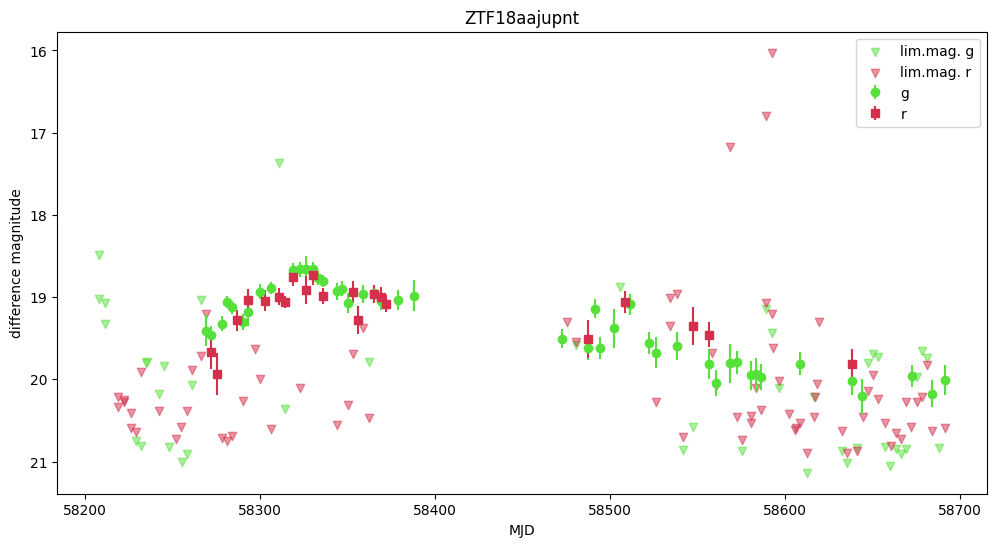

In [11]:
results = getLCdata(seloid, doLC=True, plot_diff = True)

And the object's corrected light curve, showing only the detections

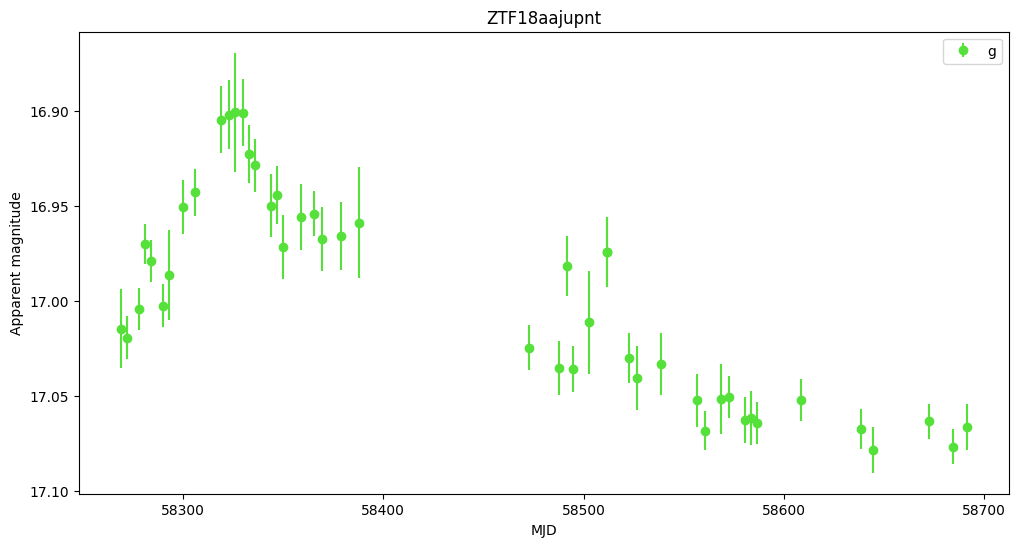

In [12]:
results = getLCdata(seloid, doLC=True)

ZTF18aajupnt (AT2018dyk) was classified as a changing-look LINER by [Frederick et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...883...31F/abstract). This source was first [classified as TDE](https://wis-tns.weizmann.ac.il/object/2018dyk/classification-cert), however its light curve does not show the power-law decline characteristic of an optical TDE. Frederick et al. 2019 performed a detailed multi-wavelength photometric and spectroscopic analysis of this target (see Section 3.6), and demonstrated that ZTF18aajupnt is an "extreme" changing-look LINER, which transitioned into a narrow-line Seyfert 1 (NLS1).

ZTF18aajupnt is classified as AGN by the light curve classifier, with a probability of 0.43.

Note the difference between the difference and corrected light curves. The corrected light curve of ZTF18aajupnt is much redder. 




It is important to use the corrected light curve for variability analyses, in particular for sources with changes in the sign of the difference between the reference and the science image. This can be seen in the light curve of Mrk 817 (ZTF18aamgjku):

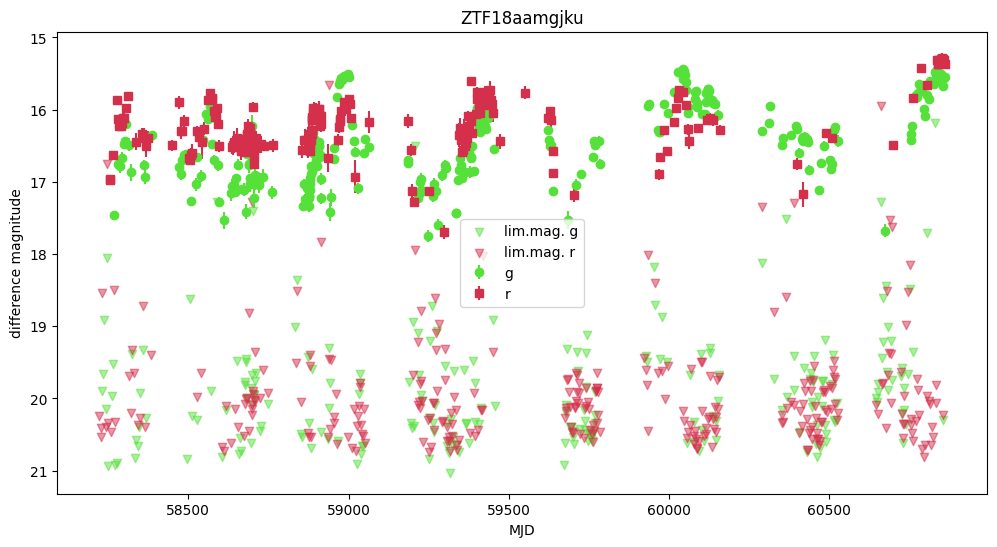

In [13]:
seloid = "ZTF18aamgjku"
results = getLCdata(seloid, doLC=True, plot_diff = True)

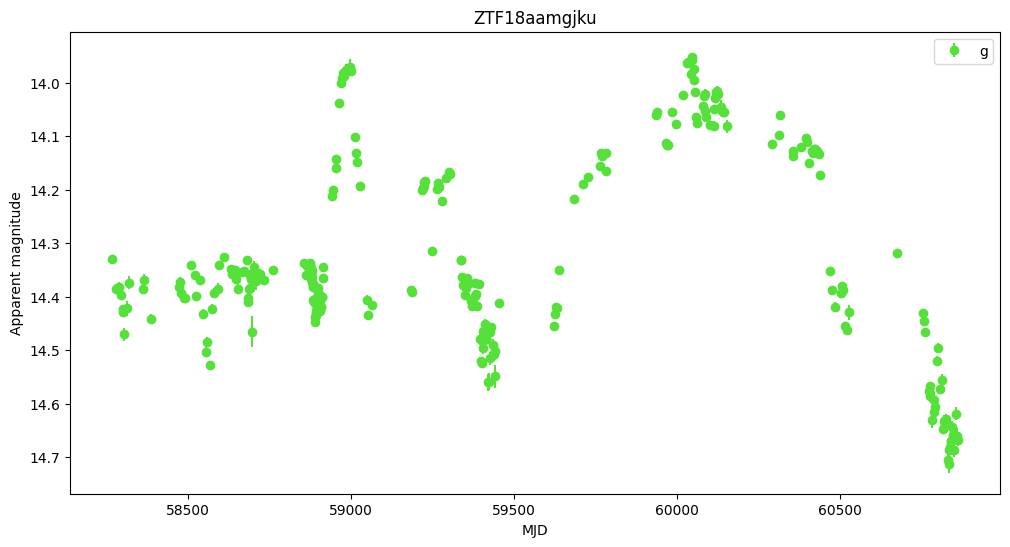

In [14]:
results = getLCdata(seloid, doLC=True)

This target (Mrk 817) is particularly interesting, since it presents a change in the sign of the difference between the reference and the science image, therefore the real shape of the light curve cannot been clearly distinguished using from the difference magnitude light curve. That is why is very important for the study of active galaxies to always use the apparent or corrected magnitude light curve. Hereafter we will use the corrected light curves. 

 

# Advanced plotting functions including dust and distance attenuation corrections  <a class="anchor" id="advancedfunctions"></a>

We will modify our previous function (plot_corrLC) and now we will be able to receive a dictionary with attenuations due to Galactic extinction, as well as the redshift. This will allow us to get absolute magnitudes (assuming no K-corrections), and to 
transform the light curve to the source rest frame. Note that we use astroquery Distance and WMAP7 objects, as well as mag units.

In [15]:
def plotLC(oid, LC_det, A=None, redshift=None):
    fig, ax = plt.subplots(figsize = (12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    
    # distmod: distance modulus, reftime: reference time
    if redshift is not None:
        distmod = float(Distance(z=redshift, cosmology=WMAP7).distmod / u.mag)
        reftime = LC_det.mjd.min()
    else:
        distmod = 0
        reftime = 0
        redshift = 0
        
    # loop the passbands
    for fid in [1, 2]:
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            # change time to restframe days if redshift is not zero
            times = (LC_det[mask].mjd - reftime) / (1. + redshift)
            
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(times, LC_det[mask].magpsf_corr - distmod, 
                            yerr=LC_det[mask].sigmapsf_corr_ext, c=colors[fid],
                            fmt=markers[fid], label = labels[fid], alpha=0.1)
                # show dust and distance attenuation corrected light curve
                ax.errorbar(times, LC_det[mask].magpsf_corr - A_fid - distmod,
                            yerr=LC_det[mask].sigmapsf_corr_ext, c=colors[fid],
                            fmt=markers[fid], label = "%s (ext. corr.)" % labels[fid])
            else:
                # correct only for redshift
                ax.errorbar(times, LC_det[mask].magpsf_corr - distmod, 
                            yerr=LC_det[mask].sigmapsf_corr_ext - A_fid, c=colors[fid],
                            fmt=markers[fid], label=labels[fid])
        
            
    # labels
    if A is not None and redshift != 0:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$, z=%.4f)" % (oid, A["g"], A["r"], redshift))
    elif redshift != 0:
        ax.set_title("%s (z=%.4f)" % (oid, redshift))
    elif A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)
        
    if redshift == 0:
        ax.set_xlabel("MJD")
        ax.set_ylabel("Apparent magnitude")
    else:
        ax.set_xlabel("Restframe time [days]")
        ax.set_ylabel("Absolute magnitude (no K-corr.)")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

Now we test these functions with the same AGN as before (Mrk 817). This source has a known spectrocopic redshift, but this is usually not the case.

We will also modify the getLCdata function to get all the necessary information given the object id (oid). It now does the following:
 - display a link to the ALeRCE explorer page for this object
 - get the basic object statistics, this includes the position in the sky (using the ALeRCE client)
 - get the detections (using the ALeRCE client). Non-detections are excluded now.
 - get the Milky Way dust attenuation at the given position in the sky (using astroquery IrsaDust)
 - plot the apparent magnitude light curve corrected for dust attenuation (using the previously defined function)
 - query NED to get the redshift, using astroquery Ned, and a radius of 2 arcseconds
 - plot the absolute magnitude light curve correction for Milky Way dust and distance attenuation, in restframe time and ignoring k-corrections (using the previously defined plotLC function)
 - plot the first image stamps associated to this source (using the ALeRCE client)

In [16]:
def getLCdata(oid, doLC=False, doext=False, dostamp=False,
              doNED=False, doredshift=False):

    results = {"oid": oid}
    
    # query basic stats
    LC_stats = client.query_object(oid, format='pandas')
    results["stats"] = LC_stats
    
    # query detections
    LC_det = client.query_detections(oid, format='pandas')
    results["lc_det"] = LC_det
    
    # object coordinates
    co = coordinates.SkyCoord(ra=LC_stats.meanra[0], dec=LC_stats.meandec[0],
                              unit=(u.deg, u.deg), frame='fk5')
    
    # get galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"][0]),
             "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"][0])}
        results["attenuation"] = A

    # plot the LC
    if doLC:
        if doext:
            plotLC(oid, LC_det, A)
        else:
            plotLC(oid, LC_det)
            
    # find NED galaxies
    if doNED:
        Ned_table = Ned.query_region(co, radius=2.0 * u.arcsec, equinox='J2000.0')
        display(Ned_table)
        results["ned_table"] = Ned_table
        
        # save closest redshift if any
        df_ned = Ned_table.to_pandas()
        mask=df_ned.Redshift.notna()
        if mask.sum() > 0:
            results["redshift"] = df_ned.loc[df_ned.loc[mask].Separation.idxmin()].Redshift
            print("Redshift found: %s" % results["redshift"])
            
    # plot absolute value (without K-corrections)
    if doredshift:
        if type(doredshift) == float and doredshift > 0:
            results["redshift"] = doredshift
        if "redshift" in results.keys():
            if doext:
                plotLC(oid, LC_det, A, results["redshift"])
            else:
                plotLC(oid, LC_det, results["redshift"])            
    
    
    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))
    
    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = client.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        for idx, im in enumerate([np.log(science), np.log(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace=0, hspace=0)
        
    # return data
    return results

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,UGC 09412,219.09202,58.7943,G,9392.0,0.031328,SUN,14.6r,0.002,518,8,200,70,102,9,0


Redshift found: 0.031328


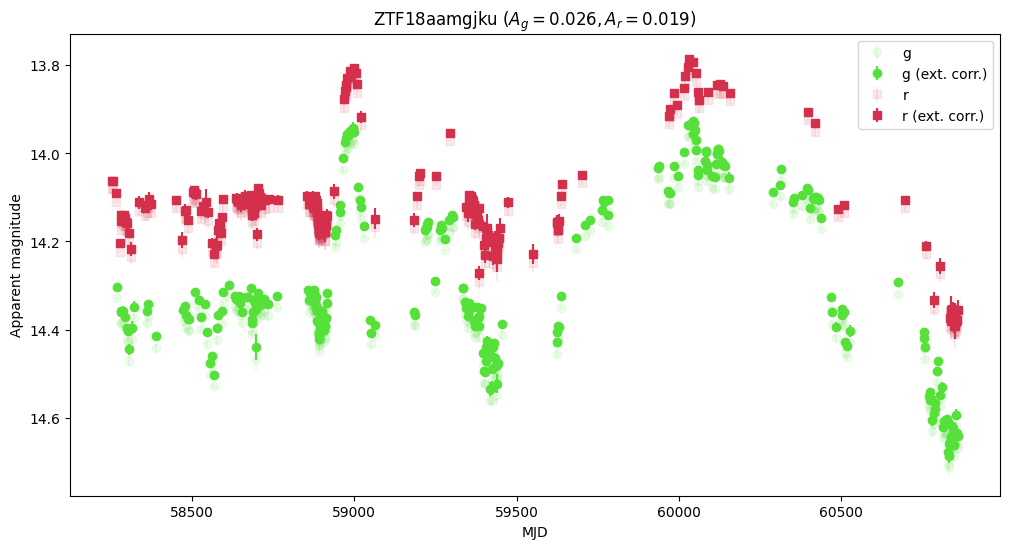

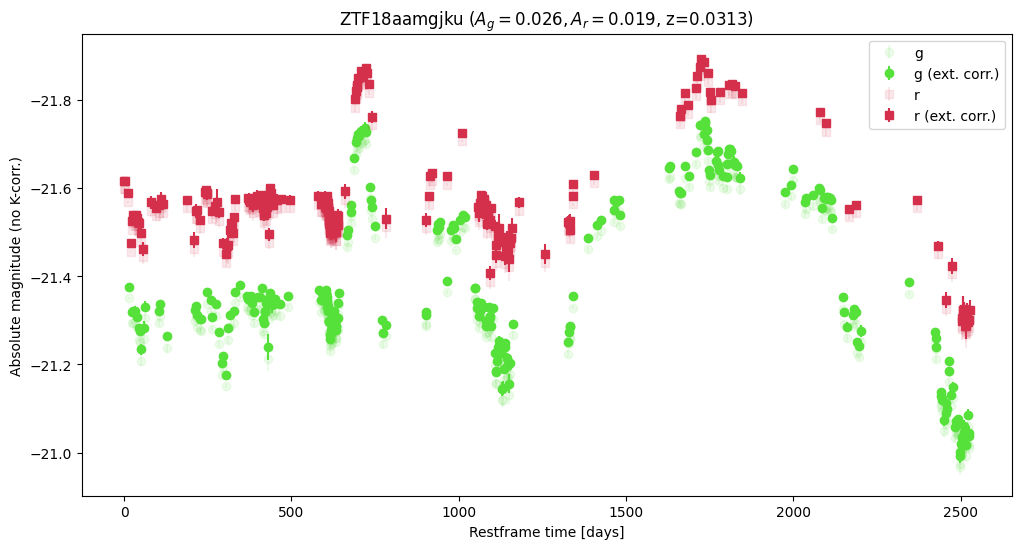

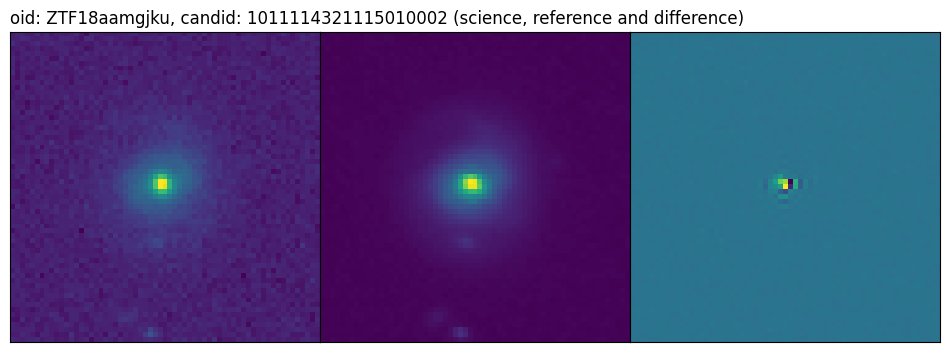

In [17]:
results_1st_target = getLCdata(seloid, doLC=True, doext=True, dostamp=True, doNED=True, doredshift=True)

This source has the typical absolute magnitude observed for low redshift active galaxies. 

You can also force the absolute magnitude plot by giving the redshift manually. This may be necessary if there is not a redshift in NED or you need to use a much larger search radius to find it automatically. In this case we selected a source classified as GALAXY by the DR16 catalog "DR16Q_Superset_v3" ([Lyke et al. 2020]( https://ui.adsabs.harvard.edu/abs/2020arXiv200709001L/abstract)). 

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J013859.14+260015.7,24.74643,26.00438,RadioS,--,--,,1.43,0.004,8,0,21,9,0,0,0


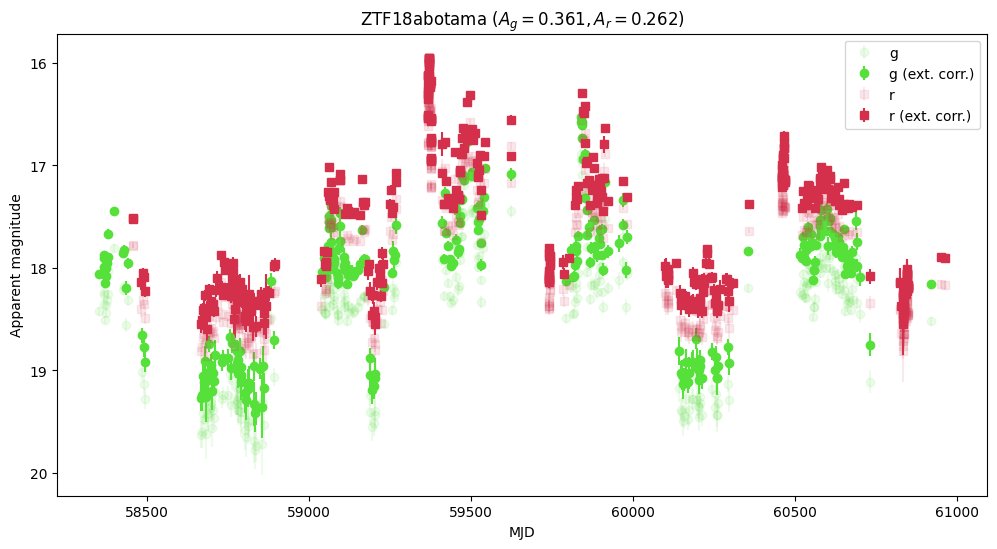

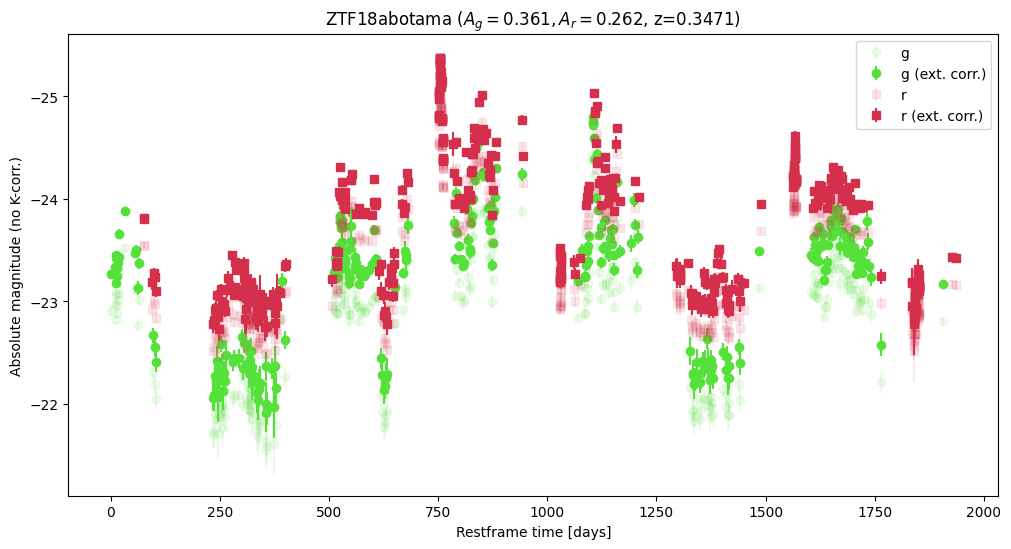

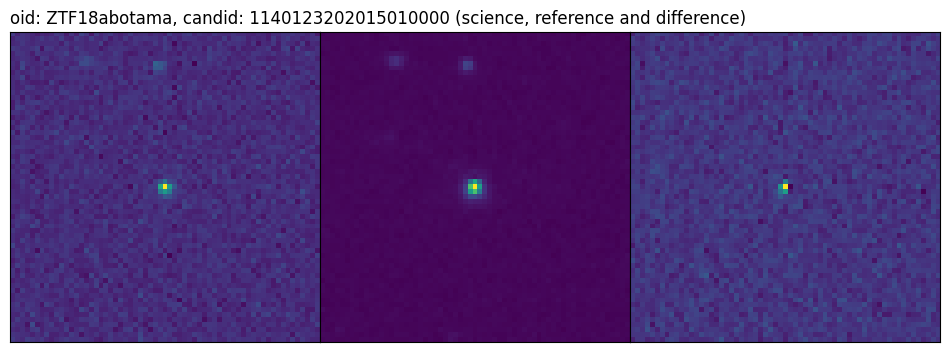

In [18]:
results_2nd_target = getLCdata("ZTF18abotama", doLC=True, doext=True,
                               dostamp=True, doNED=True, doredshift=0.3471357);

It can be seen that this source shows a variable flux, but its [SDSS spectra](http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx?ra=24.746433972028&dec=26.0043609167832) shows no clear signal of SMBH activity 

# Using Aladin   <a class="anchor" id="aladdin"></a>

We can show an image from Aladin to see the source and its environment (we could also use ipyaladin for more interactivity, but it is not currently working in Colab). In this case we continue working with Mrk 817.

In [19]:
# Use the example code from Aladin Lite
def show_image(results):
    query = """
<!-- include Aladin Lite CSS file in the head section of your page -->
<link rel="stylesheet" href="https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.css" />
 
<!-- you can skip the following line if your page already integrates the jQuery library -->
<script type="text/javascript" src="https://code.jquery.com/jquery-1.12.1.min.js" charset="utf-8"></script>
 
<!-- insert this snippet where you want Aladin Lite viewer to appear and after the loading of jQuery -->
<div id="aladin-lite-div" style="width:800px;height:400px;"></div>
<script type="text/javascript" src="https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.js" charset="utf-8"></script>
<script type="text/javascript">
    var aladin = A.aladin('#aladin-lite-div', {survey: "P/PanSTARRS/DR1/color-z-zg-g", fov:0.04, target: "%s, %s"});
</script>
""" % (float(results["stats"].meanra.iloc[0]), float(results["stats"].meandec.iloc[0]))
    display(HTML(query))

In [20]:
# this uses the results from the last getSNdata call
show_image(results_1st_target)

# Query many AGN and QSO candidates using the client <a class="anchor" id="agniaclient"></a>

The ALeRCE client allows users to access the ALeRCE API and do simple queries to our database. You can get information about each command using the help command.

In [21]:
help(client.query_objects)

Help on method query_objects in module alerce.search:

query_objects(format='pandas', index=None, sort=None, **kwargs) method of alerce.core.Alerce instance
    Gets a list of objects filtered by specified parameters.
    It is strongly advised to look at the documentation of `ALERCE ZTF API`_
    
    Parameters
    ----------
    format : str
        Return format. Can be one of 'pandas' | 'votable' | 'json'
    index : str
        Name of the column to use as index when format is 'pandas'
    sort : str
        Name of the column to sort when format is 'pandas'
    
    **kwargs
        Keyword arguments. Each argument can be one of the `ALERCE ZTF API`_
        object query parameters.
    
        - classifier : str
            classifier name
        - class_name : str
            class name
        - ndet : int[]
            Range of detections.
        - probability : float
            Minimum probability.
        - firstmjd : float[]
            First detection date range in m

### Querying the ALeRCE database

We will now query the top 3000 AGN and top 3000 QSO candidates, that have a probability > 0.6 of being a AGN according to the light curve classifier, and which have between 30 and 200 detections.

In [22]:
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd

AGNs = client.query_objects(classifier="lc_classifier",
                           class_name="AGN", 
                           probability=0.6,
                           ndet=[30, 200],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           count=False,
                           page_size=3000, format='pandas')
print(AGNs.shape)
AGNs.set_index("oid", inplace=True)
AGNs.head()

(3000, 23)


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aasazmy,151,1197,58487.507882,59022.204120,True,False,34,-0.052259,0.772552,0.038235,...,59022.204120,415.785706,230.258735,35.879741,0.000191,0.000054,AGN,lc_classifier,0.980036,corr_bulk_0.0.1
ZTF19aaxqrku,247,1203,58315.250000,60086.250000,True,False,158,0.113400,0.603239,0.140566,...,60086.184850,1445.947697,188.825378,75.543783,0.000251,0.000062,AGN,lc_classifier,0.978072,1.2.0
ZTF18aceqrsl,91,1770,58429.474537,60823.184560,True,False,44,NaN,NaN,NaN,...,60823.184560,2057.679016,160.484705,28.203514,0.011391,0.010039,AGN,lc_classifier,0.978000,27.5.6
ZTF19acawxnt,168,2443,58723.322118,60948.136690,True,False,131,NaN,NaN,NaN,...,60948.136690,2224.814572,254.319635,75.130556,0.023640,0.006066,AGN,lc_classifier,0.974088,27.5.6
ZTF20aadbsnc,155,1817,58249.256817,59527.493218,True,False,52,-0.183000,0.470609,0.034143,...,59527.493218,634.269421,181.450763,58.804058,0.000138,0.000060,AGN,lc_classifier,0.974048,correction_1.0.6


In [23]:
QSOs = client.query_objects(classifier="lc_classifier",
                           class_name="QSO", 
                           probability=0.6,
                           ndet=[30, 200],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           count=False,
                           page_size=3000, format='pandas')
print(QSOs.shape)
QSOs.set_index("oid", inplace=True)
QSOs.head()

(3000, 23)


,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
oid,,,,,,,,,,,,,,,,,,,,,
ZTF20aajbofc,293,2730,58875.380556,60797.281412,True,False,93,NaN,NaN,NaN,...,60797.281412,1646.765856,175.619865,30.685208,0.008379,0.007206,QSO,lc_classifier,0.990,26.0.1
ZTF19adceucq,182,1260,58487.465474,59336.215706,True,True,88,-0.224499,-0.040526,-0.126013,...,59336.215706,498.716644,152.433177,47.057296,0.000113,0.000058,QSO,lc_classifier,0.986,correction_0.0.1
ZTF19aalbcna,294,3167,58441.508356,60854.281435,True,False,32,NaN,NaN,NaN,...,60854.281435,1181.953356,203.151292,49.934326,0.018857,0.012138,QSO,lc_classifier,0.986,27.5.6
ZTF21aalvdaa,83,1185,58601.283600,59346.290625,True,True,32,0.160790,0.281669,0.177527,...,59346.289687,95.922488,175.374926,34.903529,0.000073,0.000081,QSO,lc_classifier,0.984,correction_0.0.1
ZTF19aascizh,243,2604,58586.413947,59464.159792,True,True,54,0.040600,0.085776,-0.114813,...,59464.159792,236.683252,249.412912,58.267255,0.000147,0.000062,QSO,lc_classifier,0.984,correction_1.0.6


Here you can see the fields available in the dataframe

In [24]:
", ".join(list(AGNs))

'ndethist, ncovhist, mjdstarthist, mjdendhist, corrected, stellar, ndet, g_r_max, g_r_max_corr, g_r_mean, g_r_mean_corr, firstmjd, lastmjd, deltajd, meanra, meandec, sigmara, sigmadec, class, classifier, probability, step_id_corr'

This table contains the unique object identifier `oid` as index, the classification class `class`, whether its light curve was corrected `corrected`, the light curve length `deltjd`, the time of first detection `firstmjd`, the g-r color at maximum `g_r_max`, the corrected g-r color at maximum `g_r_max_corr`, the mean g-r color `g_r_mean`, the corrected mean g-r color `g_r_mean_corr`, the time of last detection `lastmjd`, the mean declination `meandec`, the mean right ascension `meanra`, the latest time of a raw SNR$\sim 3$ detection `mjdendhist`, the earliest time of a raw SNR$\sim 3$ detection `mjdstarthist`, the number of times the candidate fell inside on a ZTF observation `ncovhist`, the number of detections `ndet`, the number of raw SNR$\sim 3$ detection `ndethist`, the classification probability `probability`, the declination standard deviation `sigmadec`, the right ascension standard deviation `sigmara`, whether the object is likely stellar `stellar`, and the version of the preprocessing step `step_id_corr`.

Now we show the corrected mean g-r color `g_r_mean_corr` distribution of AGNs and QSOs:

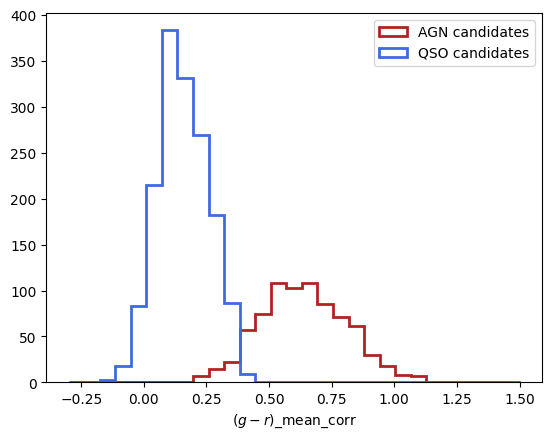

In [25]:
fig, ax = plt.subplots()
bins = np.linspace(-0.3, 1.5, 30)
ax.hist(AGNs.g_r_mean_corr,bins = bins, lw=2, histtype='step',
        color="firebrick", label="AGN candidates")
ax.hist(QSOs.g_r_mean_corr, bins=bins, lw=2, histtype='step',
        color="royalblue", label="QSO candidates")
ax.set_xlabel(r"($g-r$)_mean_corr")
plt.legend();

And the mean g-r color `g_r_mean` (i.e., measured from the difference images) distribution of AGNs and QSOs:

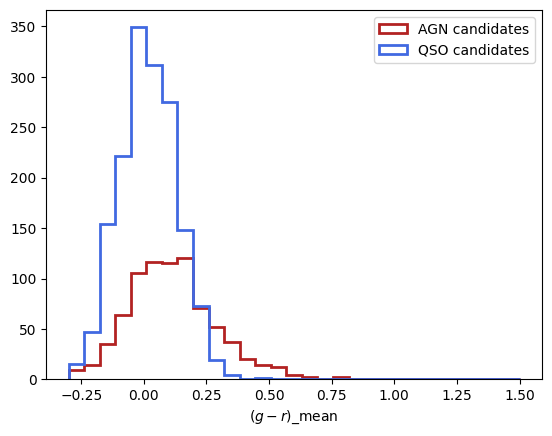

In [26]:
fig, ax = plt.subplots()
bins = np.linspace(-0.3, 1.5, 30)
ax.hist(AGNs.g_r_mean,bins = bins, lw=2, histtype='step',
        color="firebrick", label="AGN candidates")
ax.hist(QSOs.g_r_mean, bins=bins, lw=2, histtype='step',
        color="royalblue", label="QSO candidates")
ax.set_xlabel(r"($g-r$)_mean")
plt.legend();

Clearly AGNs are much redder than QSOs when we use the corrected magnitudes, while when we consider the difference magnitudes their color distributions are not so different.

Finall, we try some random AGNs from the selected sample. Some of them will have a known redshift.

In [27]:
agn_sel = np.random.choice(AGNs.index, size=5)

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J100321.10+154215.7,150.83795,15.70437,G,84424.0,0.281609,SLS,19.4g,0.005,2,0,41,6,1,4,0


Redshift found: 0.281609


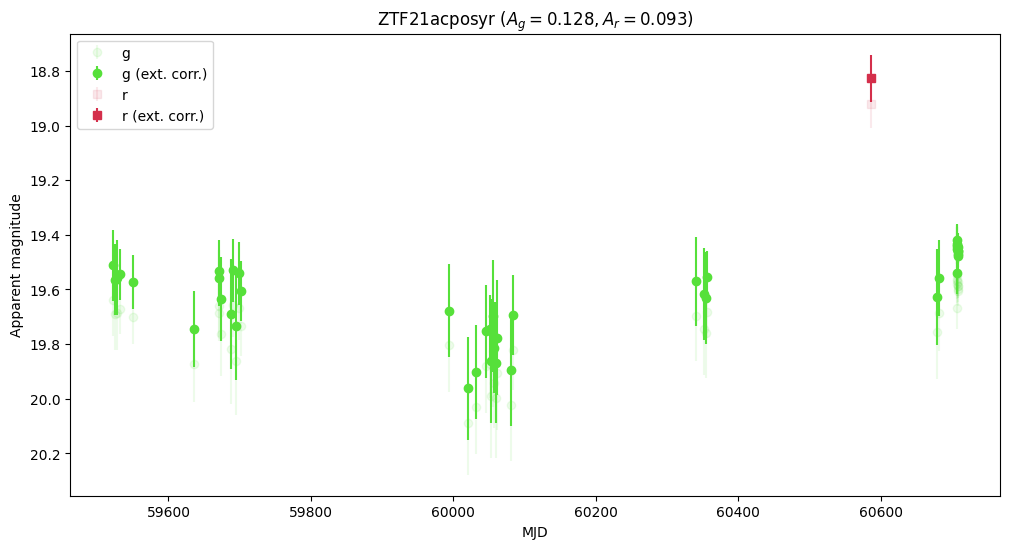

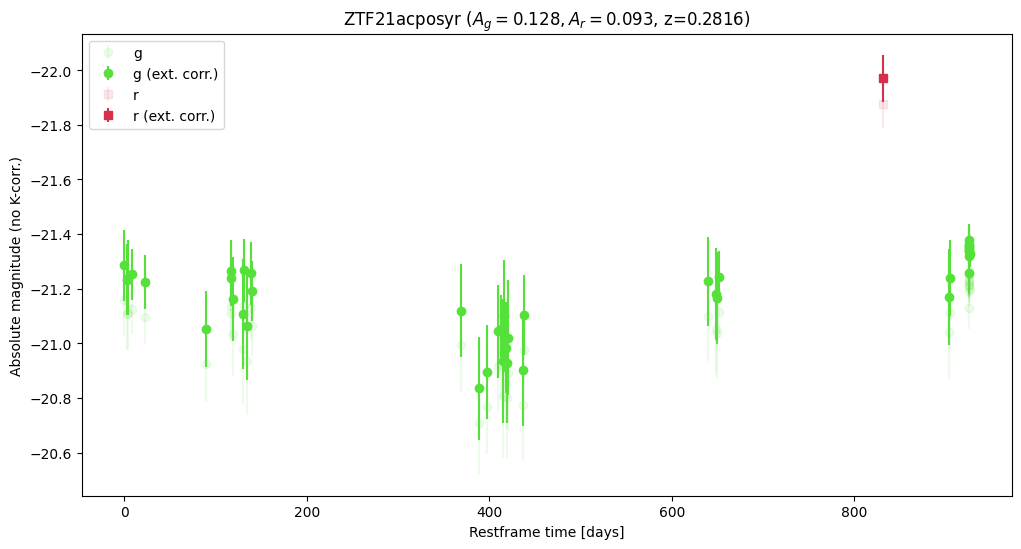

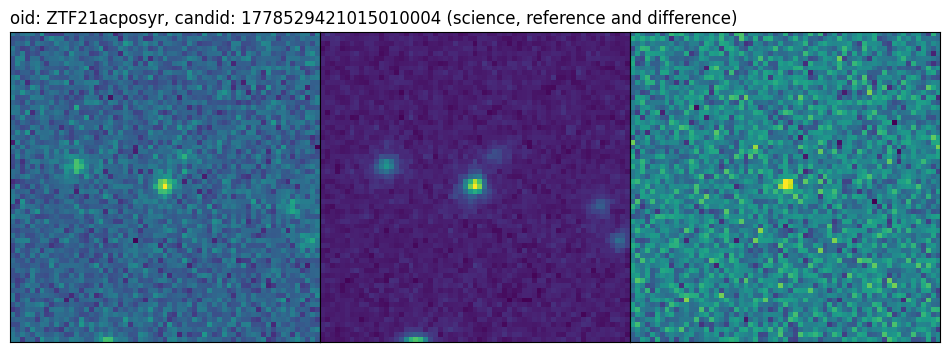

In [28]:
results = getLCdata(agn_sel[0], doLC=True, doext=True,
                    dostamp=True, doNED=True, doredshift=True)

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J103858.43+401058.4,159.74348,40.18289,G,27609.0,0.092095,SLS,16.9g,0.002,29,0,63,14,8,10,1


Redshift found: 0.092095


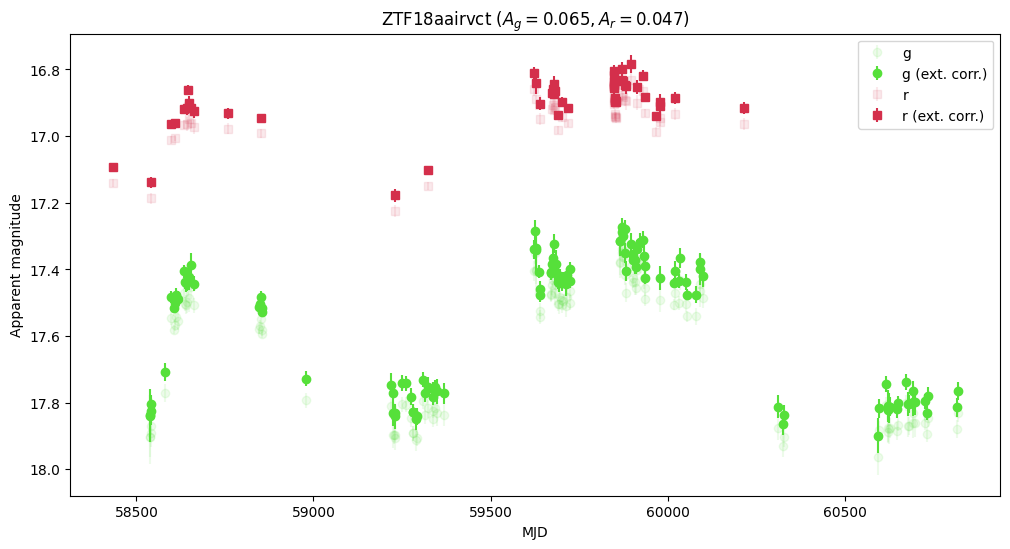

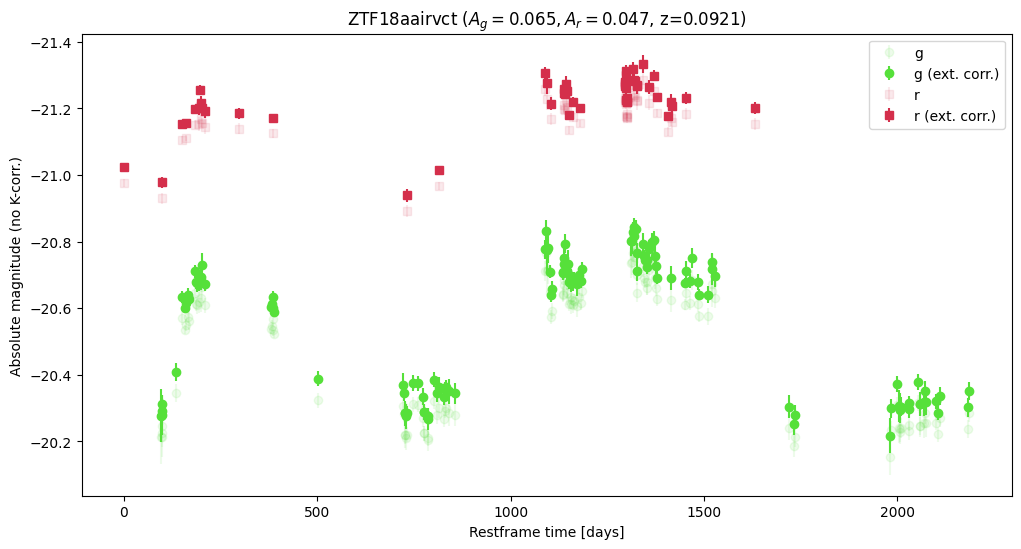

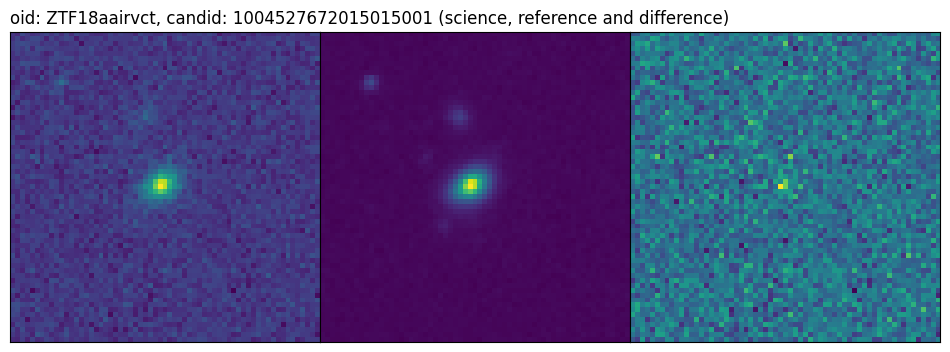

In [29]:
results = getLCdata(agn_sel[1], doLC=True, doext=True,
                    dostamp=True, doNED=True, doredshift=True)

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J073747.43+410647.9,114.44763,41.11331,G,96814.0,0.322936,SLS,18.9g,0.002,19,0,57,9,10,8,0


Redshift found: 0.322936


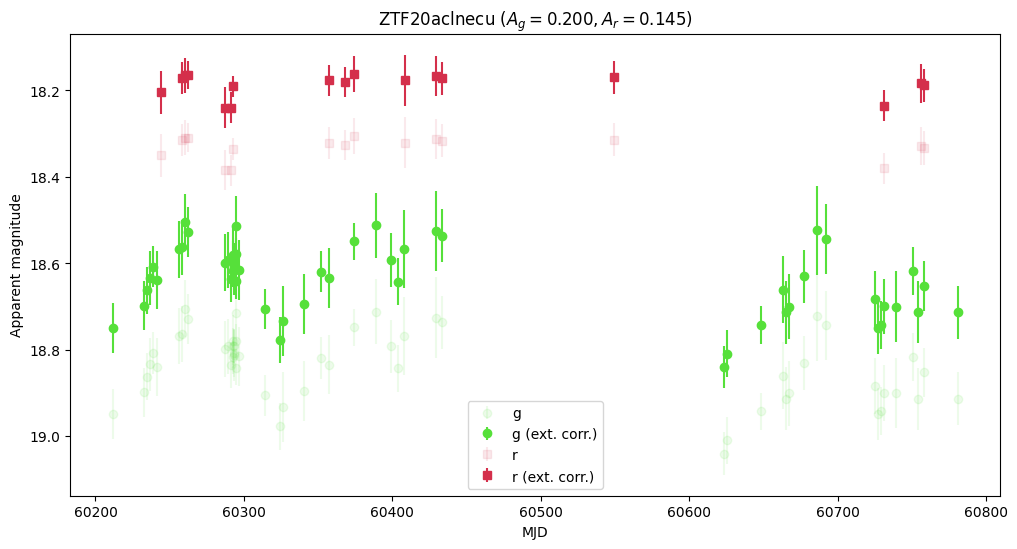

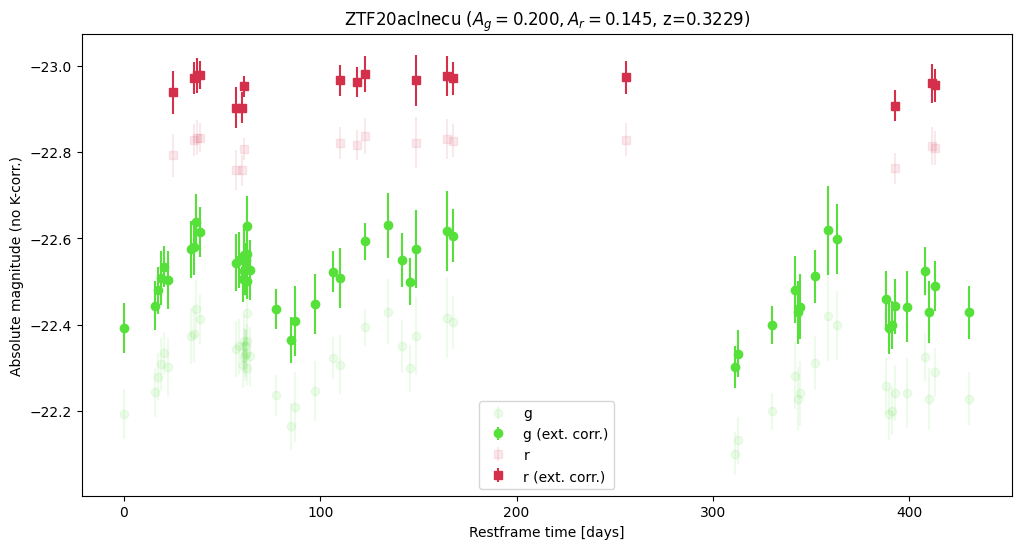

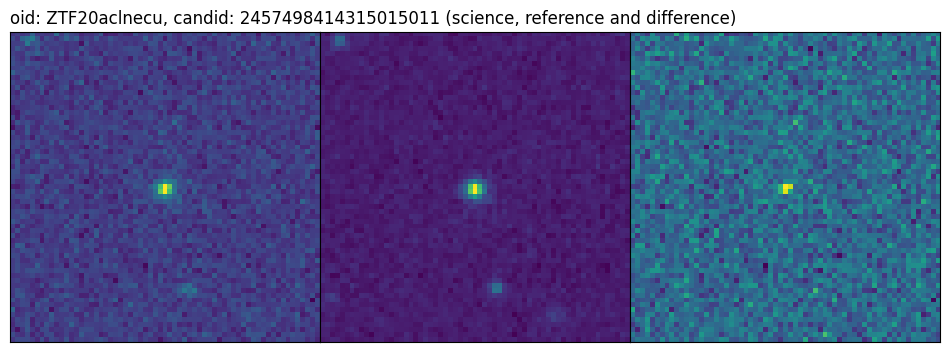

In [30]:
results = getLCdata(agn_sel[2], doLC=True, doext=True,
                    dostamp=True, doNED=True, doredshift=True)

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J142918.26-182622.4,217.32612,-18.43956,G,57132.0,0.190572,PUN,,0.004,1,0,27,4,1,2,0


Redshift found: 0.190572


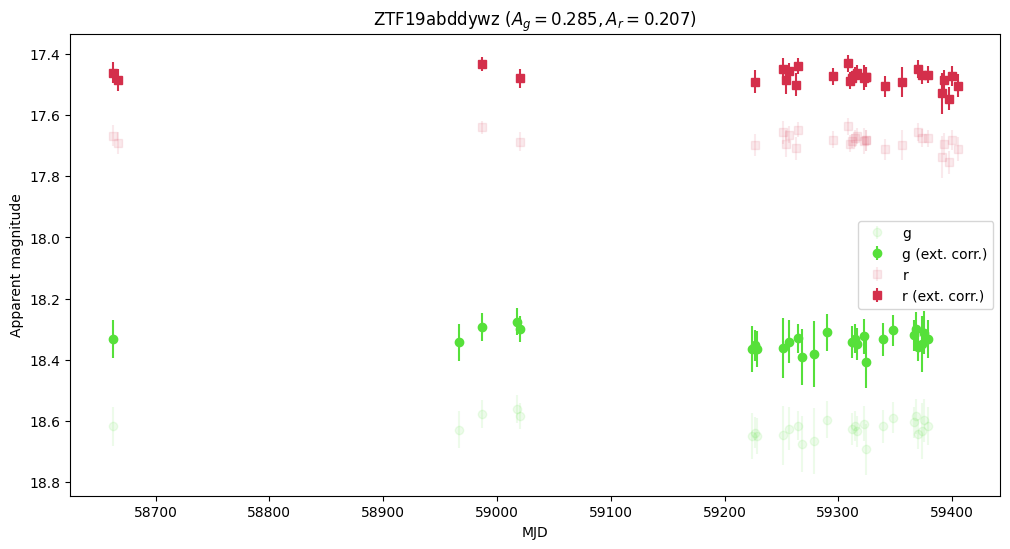

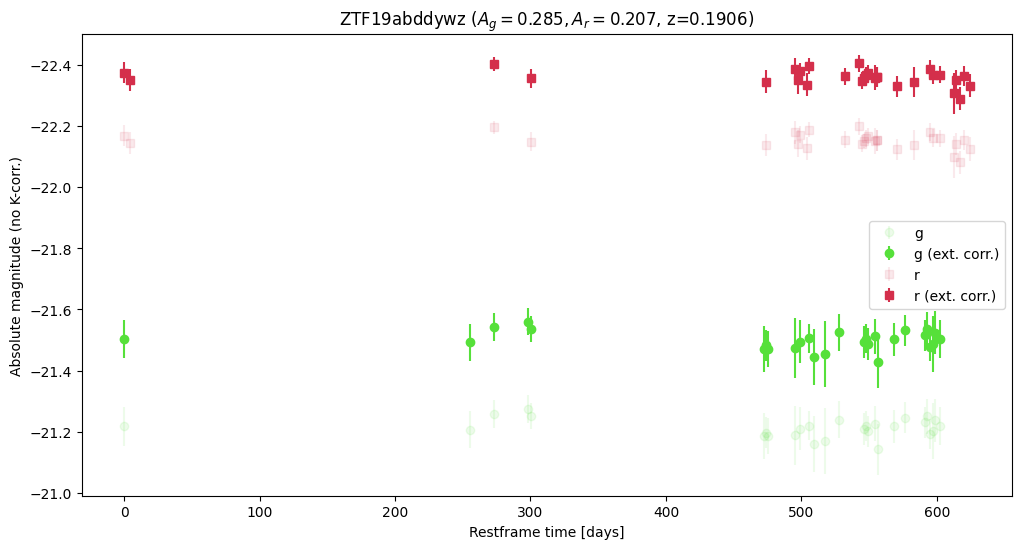

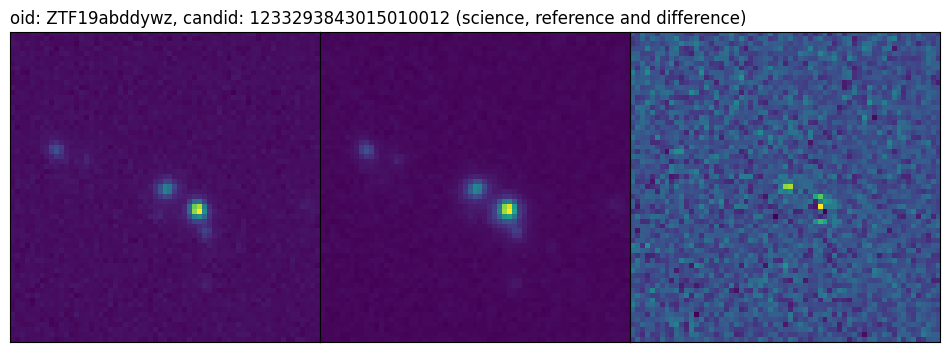

In [31]:
results = getLCdata(agn_sel[3], doLC=True, doext=True,
                    dostamp=True, doNED=True, doredshift=True)

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J180141.15+543558.6,270.42147,54.59962,UvS,--,--,,,0.006,0,0,22,3,0,0,0


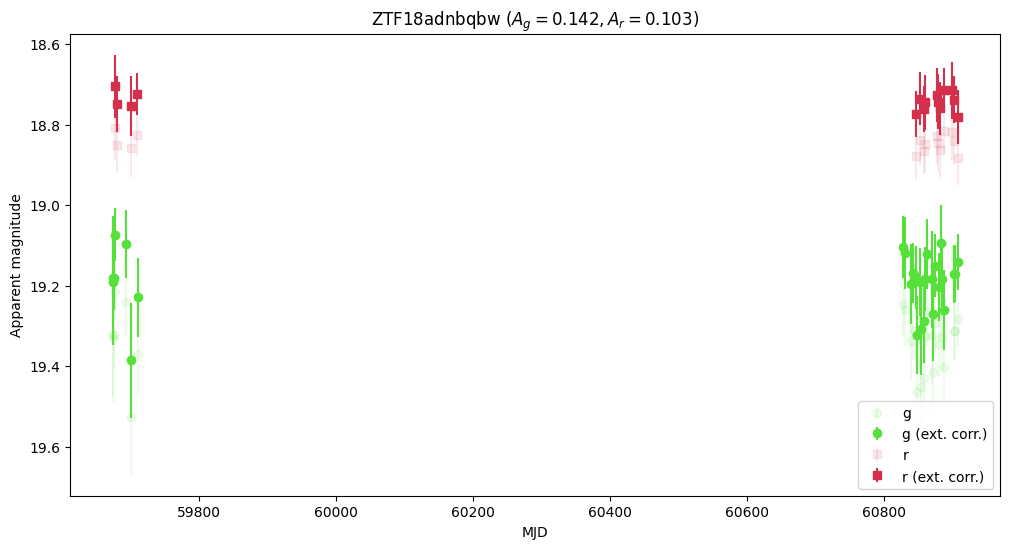

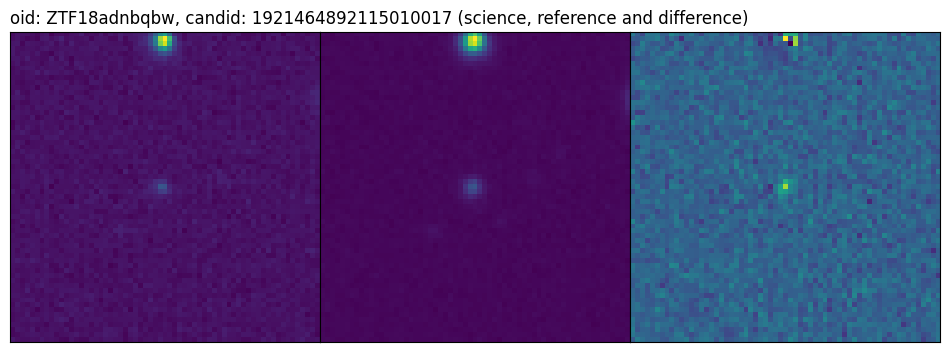

In [32]:
results = getLCdata(agn_sel[4], doLC=True, doext=True,
                    dostamp=True, doNED=True, doredshift=True)

# Query many AGN, QSO, and Blazar candidates using a direct DB connection <a class="anchor" id="agndb"></a>

The previous way of querying candidates is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here.

First, you need to install and import SQLAlchemy

In [33]:
import sqlalchemy as sa

Then, you will need to use the read only credentials available in the repository

In [34]:
import json
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

Now we open a connection to the DB

In [35]:
engine = sa.create_engine("postgresql+psycopg2://" + params["user"] \
                          + ":" + params["password"] + "@" + params["host"] \
                          + "/" + params["dbname"])
conn = engine.connect()

And we show all the available tables

In [36]:
query = """
SELECT table_name  FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="table_name")

,table_name
0,alembic_version
1,allwise
2,dataquality
3,detection
4,feature
5,feature_version
6,forced_photometry
7,gaia_ztf
8,lc_classifier
9,lc_classifier_beta


You can see all the tables used in the new version of our database. The most relevant tables are, moving from less to more aggregation:

* `non_detection`: one row per non-detection per object, the limiting magnitudes
* `detection`: one row per detection, light curves and other relevant time dependent information
* `data_quality`: one row per detection, data quality related time dependent information
* `magstat`: one row per object per filter, statistics per bandpass per object
* `object`: one row per object, basic object statistics
* `probability`: one row per object per classifier and class, the probabilities of every object
* `reference`: one row per object per reference image, object statistics for every reference image used
* `feature`: one row per object per feature, object computed features
* `xmatch`: one row per object per external catalog, the table that points to the detailed xmatch tables
* `allwise, ps1_ztf, gaia_ztf, ss_stf`: one row per object, xmatch tables

For completeness, we now show all columns available in all tables!

In [37]:
alltabs = []
for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,alembic_version,version_num,character varying
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision


Now we can do a query asking for sources classfied as AGN, QSO or Blazar. We define a minimum number of detections (ndet), and a minimum time span between the first and the last detection (deltajd), in order to ensure the detection of a variable signal from the light curves.  We also filter out sources by their predicted class probability. WARNING: this might take some time to run...


In [38]:
query = '''
SELECT
    object.oid, object.meanra, object.meandec, object.ndet,
    object.firstMJD, object.deltajd, object.g_r_mean_corr,
    probability_oid.classifier_name, probability_oid.classifier_version,
    probability_oid.class_name, probability_oid.ranking,
    probability_oid.probability
FROM
    object INNER JOIN (
    SELECT
        oid, classifier_name, classifier_version,
        class_name, ranking, probability
    FROM
        probability
    WHERE
        classifier_name = 'lc_classifier'
        AND class_name IN ('AGN', 'QSO', 'Blazar')
        AND ranking = 1
        AND probability > 0.8

    ) AS probability_oid
    ON object.oid = probability_oid.oid
WHERE
    probability_oid.classifier_name = 'lc_classifier'
    AND object.deltajd > 200
    AND object.ndet > 100
'''

objects = pd.read_sql_query(query, conn)
objects.drop_duplicates(subset=["oid"], keep='last', inplace=True)
print(objects.shape)
objects.set_index('oid', inplace=True)
objects.head()

(17961, 12)


,meanra,meandec,ndet,firstmjd,deltajd,g_r_mean_corr,classifier_name,classifier_version,class_name,ranking,probability
oid,,,,,,,,,,,
ZTF20aagmsvm,173.107989,10.206926,119,58954.231817,771.950150,0.216593,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.854000
ZTF20abftrse,250.668171,40.125933,213,58987.343206,1944.814317,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.808380
ZTF19adgybqq,244.688997,68.918940,146,59673.303958,1258.856898,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.812372
ZTF20aavsdpi,205.726524,28.468329,108,58962.341354,1894.852778,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.812000
ZTF22ablbqsf,141.242701,-1.437271,133,59856.515336,903.759155,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.811132


How many sources are classified as QSOs, AGNs or Blazars?

In [39]:
print("QSO: ", len(objects.loc[objects["class_name"] == "QSO"]))
print("AGN: ", len(objects.loc[objects["class_name"] == "AGN"]))
print("Blazar: ", len(objects.loc[objects["class_name"] == "Blazar"]))

QSO:  14432
AGN:  3261
Blazar:  268


We save the object IDs (oid) of each source, which will be used in the next sections:

In [40]:
oids_objects = objects.index.values
print(len(oids_objects))
print(oids_objects)

17961
['ZTF20aagmsvm' 'ZTF20abftrse' 'ZTF19adgybqq' ... 'ZTF20acjhzwq'
 'ZTF18acvgjir' 'ZTF20abwysky']


# Query AGN, QSO, and Blazar features and PS1 photometry using a direct DB connection <a class="anchor" id="agndbother"></a>

In order to understand the differences between the QSO, AGN and Blazar candidates, we search for its Pan-STARRS1 photometry, using the ps1_ztf table. WARNING: this might take some time to run...

In [41]:
chunk_size = 2000
bin_ids = np.arange(int(np.ceil(len(oids_objects) / chunk_size)))
print(str(len(bin_ids)) + ' chunks')

ps1 = pd.DataFrame()

for idx in bin_ids:
    print('Chunk ' + str(idx))
    
    index_i = idx * chunk_size
    if idx == bin_ids[-1]:
        index_f = len(oids_objects)
    else:
        index_f = (idx + 1) * chunk_size
    
    if index_i == index_f:
        continue

    names = np.array(oids_objects)[index_i:index_f].tolist()
    #print(names)

    query = '''
    SELECT
        oid, sgmag1, srmag1, simag1, szmag1, sgscore1
    FROM
        ps1_ztf
    WHERE
        oid IN (%s)
    ''' % ",".join(["'%s'" % oid for oid in names])
    #print(query)
    
    df_aux = pd.read_sql_query(query, conn)
    if len(df_aux) > 0:
        ps1 = pd.concat([ps1, df_aux.drop_duplicates(
              subset=["oid"], keep='last'
        )], axis=0)
    del df_aux

ps1.set_index("oid", inplace=True)
ps1.head()

9 chunks
Chunk 0
Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8


,sgmag1,srmag1,simag1,szmag1,sgscore1
oid,,,,,
ZTF17aacedyd,17.5871,17.3031,16.7490,16.8379,0.015417
ZTF18aaacsup,16.8518,16.6654,16.3085,16.2361,0.749318
ZTF18aaacxpa,18.5633,18.2683,18.2461,18.2633,0.977375
ZTF18aaajyqa,18.9220,18.8885,18.7355,18.8223,1.000000
ZTF18aaajzfe,18.2945,18.0869,17.8760,17.8304,0.998750


We use this data to plot a color-color diagram of QSO, AGN and Blazar candidates

In [42]:
objects["g_r_ps1"] = ps1.sgmag1 - ps1.srmag1
objects["r_i_ps1"] = ps1.srmag1 - ps1.simag1
objects["i_z_ps1"] = ps1.simag1 - ps1.szmag1
objects["sgscore1"] = ps1.sgscore1 
objects.head()

,meanra,meandec,ndet,firstmjd,deltajd,g_r_mean_corr,classifier_name,classifier_version,class_name,ranking,probability,g_r_ps1,r_i_ps1,i_z_ps1,sgscore1
oid,,,,,,,,,,,,,,,
ZTF20aagmsvm,173.107989,10.206926,119,58954.231817,771.950150,0.216593,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.854000,0.0702,0.2690,-0.0159,0.998750
ZTF20abftrse,250.668171,40.125933,213,58987.343206,1944.814317,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.808380,0.2044,-0.0416,-0.0585,0.994583
ZTF19adgybqq,244.688997,68.918940,146,59673.303958,1258.856898,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.812372,0.2452,0.1731,0.1814,0.973821
ZTF20aavsdpi,205.726524,28.468329,108,58962.341354,1894.852778,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.812000,0.2338,-0.1059,-0.4292,0.952292
ZTF22ablbqsf,141.242701,-1.437271,133,59856.515336,903.759155,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,0.811132,0.0521,0.3460,-0.0868,0.992708


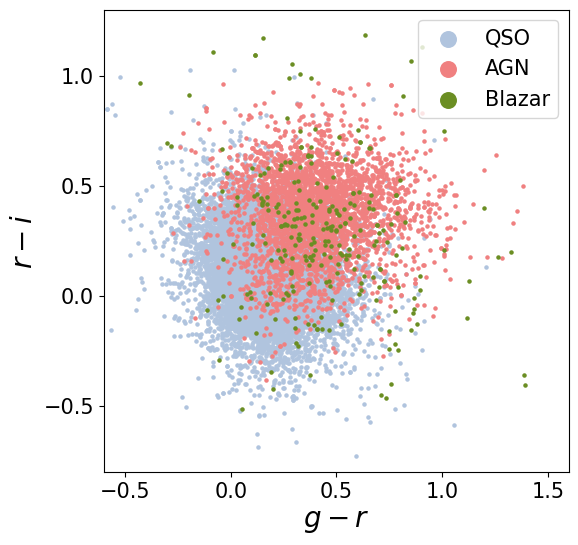

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))  

for class_name, color in [("QSO", "lightsteelblue"),
                          ("AGN", "lightcoral"),
                          ("Blazar", "olivedrab")]:
  plt.scatter(objects.loc[objects["class_name"] == class_name,
              "g_r_ps1"].values,
              objects.loc[objects["class_name"] == class_name,
              "r_i_ps1"].values, c=color, s=5, label=class_name)

plt.ylabel(r'$r-i$', fontsize=20)
plt.xlabel(r'$g-r$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.legend(fontsize=15, markerscale=5)
plt.ylim(-0.8, 1.3)
plt.xlim(-0.6, 1.6);

This color-color diagram shows that QSO candidates are bluer than AGN and Blazar candidates.

The sgscore1 corresponds to a morphological star/galaxy score of the closest source from PanSTARRS1 ([Tachibana et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASP..130l8001T/abstract)), with $0 \leq \texttt{sgscore1} \leq 1$, where values closer to 1 imply a higher likelihood of the source being a star. Let's see the distribution of the sgscore1 parameter for these sources:

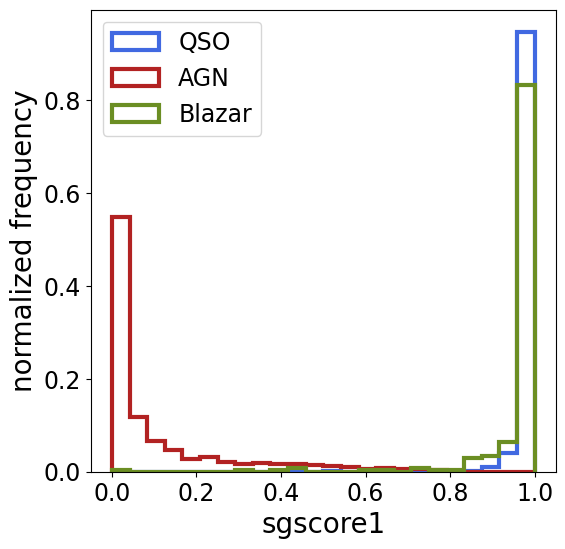

In [44]:
fig, ax = plt.subplots(figsize=(6, 6)) 
bins_hist = np.linspace(0,1,25, endpoint=True)

for class_name, color in [("QSO", "royalblue"),
                          ("AGN", "firebrick"),
                          ("Blazar", "olivedrab")]:
    weights = np.ones_like(objects.loc[objects["class_name"] \
                           == class_name,"sgscore1"].values) \
              / float(len(objects.loc[objects["class_name"] == class_name,
                          "sgscore1"].values))
    plt.hist(objects.loc[objects["class_name"] == class_name,
             "sgscore1"].values, weights=weights, cumulative=False,
             stacked=False, density=False, histtype='step', bins=bins_hist,
             lw=3, color=color, ec=color, label=class_name, alpha=1.0)
  
plt.legend(loc='upper left',fontsize=17)
plt.xlabel(r'sgscore1', fontsize=20)
plt.ylabel(r'normalized frequency', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17);

Clearly AGN candidates have more extended morphologies compared to QSOs and Blazars.


In addition, we query some relevant features for active galaxies from the feature table, like IAR_phi, GP_DRW_sigma and GP_DRW_tau, the MHPS feautres, ExcessVar, and the Structure Function features. These features are described in detail in Sánchez-Sáez et al. 2021. Note that these features are computed using the observed frame light curves (i.e., the light curves are not corrected by redshift). WARNING: this might take some time to run...

In [45]:
# Heavy query (~4 min)

chunk_size = 1000
bin_ids = np.arange(int(np.ceil(len(oids_objects) / chunk_size)))
print(str(len(bin_ids)) + ' chunks')

features = pd.DataFrame()

for idx in bin_ids:
    print('Chunk ' + str(idx))
    
    index_i = idx * chunk_size
    if idx == bin_ids[-1]:
        index_f = len(oids_objects)
    else:
        index_f = (idx + 1) * chunk_size
    
    if index_i == index_f:
        continue

    names = np.array(oids_objects)[index_i:index_f].tolist()
    #print(names)

    query = '''
    SELECT
        *
    FROM
        feature
    WHERE
        oid IN (%s)
        AND (LEFT(name, 4) = 'MHPS'
        OR LEFT(name, 3) = 'GP_')
        AND version = '23.12.26a85'
    ''' % ",".join(["'%s'" % oid for oid in names])
    #print(query)
    
    df_aux = pd.read_sql_query(query, conn)
    if len(df_aux) > 0:
        features = pd.concat([features, df_aux], axis=0)
    del df_aux

features.head()

18 chunks
Chunk 0
Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6
Chunk 7
Chunk 8
Chunk 9
Chunk 10
Chunk 11
Chunk 12
Chunk 13
Chunk 14
Chunk 15
Chunk 16
Chunk 17


,oid,name,value,fid,version
0,ZTF18aaaofyn,GP_DRW_sigma,0.012984,1,23.12.26a85
1,ZTF18aaaofyn,GP_DRW_sigma,0.008054,2,23.12.26a85
2,ZTF18aaaofyn,GP_DRW_tau,1918.005175,1,23.12.26a85
3,ZTF18aaaofyn,GP_DRW_tau,1041.776767,2,23.12.26a85
4,ZTF18aaaofyn,MHPS_high,0.006230,1,23.12.26a85


You can see that each object has one row per feature per band. Let's show the unique feature names:

In [46]:
features.name.unique()

array(['GP_DRW_sigma', 'GP_DRW_tau', 'MHPS_high', 'MHPS_low',
       'MHPS_non_zero', 'MHPS_PN_flag', 'MHPS_ratio'], dtype=object)

In [47]:
features.oid.unique()

array(['ZTF18aaaofyn', 'ZTF18aaaoqom', 'ZTF18aacdpff', ...,
       'ZTF25aahxgso', 'ZTF25aahxiri', 'ZTF25aakgvan'], dtype=object)

Let's save these features in a new dataframe to make their manipulation easier 

In [48]:
features["fname"] = features.name + "_" + features.fid.astype(str)
features_aux = features.pivot_table(index="oid", columns="fname", values="value")
features_aux.head()

fname,GP_DRW_sigma_1,GP_DRW_sigma_2,GP_DRW_tau_1,GP_DRW_tau_2,MHPS_PN_flag_1,MHPS_PN_flag_2,MHPS_high_1,MHPS_high_2,MHPS_low_1,MHPS_low_2,MHPS_non_zero_1,MHPS_non_zero_2,MHPS_ratio_1,MHPS_ratio_2
oid,,,,,,,,,,,,,,
ZTF17aaachjt,8.983149e-02,8.367810e-02,118.529082,79.031183,0.0,0.0,0.006636,0.013763,0.519846,0.477181,100.0,141.0,78.334381,34.672314
ZTF17aaaivav,1.987956e-01,2.277534e-01,41.772670,33.002304,0.0,0.0,0.038122,0.084323,2.190224,3.591656,230.0,473.0,57.453762,42.594002
ZTF17aaakeyg,5.263505e-03,8.151396e-10,80.834977,10.077321,0.0,1.0,0.000102,0.000428,0.026900,0.018585,127.0,38.0,264.486816,43.395687
ZTF17aaapjmw,2.454149e-01,2.595164e-01,25.575248,28.984400,0.0,0.0,0.091757,0.081379,2.830504,2.558223,161.0,259.0,30.847797,31.435846
ZTF17aaawmpl,1.974081e-09,1.155540e-09,1.378149,1.150947,1.0,1.0,0.002886,0.001104,0.010689,0.003111,52.0,26.0,3.704284,2.818038


In [49]:
objects = objects.join(features_aux)
objects.head()

,meanra,meandec,ndet,firstmjd,deltajd,g_r_mean_corr,classifier_name,classifier_version,class_name,ranking,...,MHPS_PN_flag_1,MHPS_PN_flag_2,MHPS_high_1,MHPS_high_2,MHPS_low_1,MHPS_low_2,MHPS_non_zero_1,MHPS_non_zero_2,MHPS_ratio_1,MHPS_ratio_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF20aagmsvm,173.107989,10.206926,119,58954.231817,771.950150,0.216593,lc_classifier,hierarchical_rf_1.1.0,QSO,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF20abftrse,250.668171,40.125933,213,58987.343206,1944.814317,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,...,1.0,1.0,0.045826,0.018267,0.045030,0.040551,92.0,99.0,0.982627,2.219858
ZTF19adgybqq,244.688997,68.918940,146,59673.303958,1258.856898,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,...,1.0,1.0,0.001362,0.001444,0.004178,0.012414,92.0,29.0,3.068124,8.594021
ZTF20aavsdpi,205.726524,28.468329,108,58962.341354,1894.852778,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,...,1.0,1.0,0.000856,0.000769,0.018865,0.013096,31.0,50.0,22.040537,17.033257
ZTF22ablbqsf,141.242701,-1.437271,133,59856.515336,903.759155,NaN,lc_classifier,hierarchical_rf_1.1.0,QSO,1,...,1.0,1.0,0.005023,0.003590,0.002308,0.011816,30.0,66.0,0.459445,3.291422


Let's see the distribution of some of these features:

First, we will plot the distribution of the Mexican Hat Power Spectrum (MHPS) features. These features are based on the method presented in [Arévalo et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.426.1793A/abstract). They proposed a method to compute low-resolution power spectra from data with gaps, where the light curves are convolved with a Mexican hat filter. This method can be used to isolate structures  with a characteristic timescale in a given light curve, in order to estimate the light curve normalized variance associated with that timescale. We compute the light curve variance at two different timescales of 10 (high frequency; MHPS\_high) and 100 days (low frequency; MHPS\_low). We also compute the ratio between the low and high frequency variances for a given band, denoted as MHPS\_ratio. The logarithm of MHPS\_ratio is therefore an estimate of the power law slope of the power spectrum of the light curve.

Below we plot the distribution of these features for the $g$ (\_1) and $r$ band (\_2)

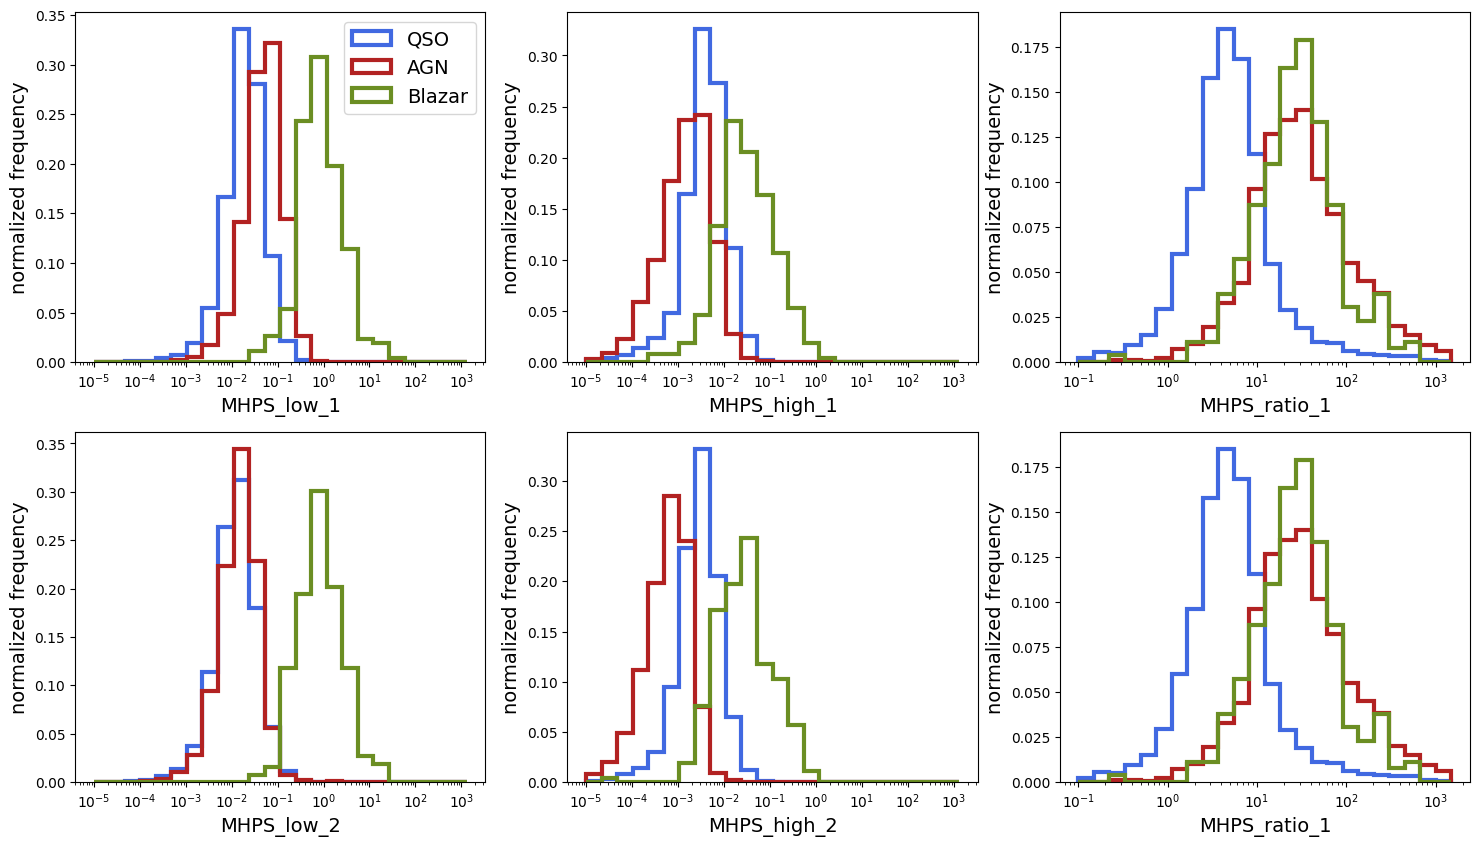

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10)) 

for feature, axr, axc in [("MHPS_low_1", 0, 0),
                          ("MHPS_high_1", 0, 1),
                          ("MHPS_ratio_1", 0, 2),
                          ("MHPS_low_2", 1, 0),
                          ("MHPS_high_2", 1, 1),
                          ("MHPS_ratio_1", 1, 2)]:
    if feature == "MHPS_ratio_1" or feature == "MHPS_ratio_2":
        bins_hist = np.logspace(np.log10(1e-1), np.log10(1500),
                                25, base=10.0, endpoint=True)
    else:
        bins_hist = np.logspace(np.log10(1e-5), np.log10(1300),
                                25, base=10.0, endpoint=True)
    
    objects_aux = objects[objects[feature] >= np.min(bins_hist)]
    for class_name, color in [("QSO","royalblue"),
                              ("AGN","firebrick"),
                              ("Blazar","olivedrab")]:
        weights = np.ones_like(objects_aux.loc[objects_aux["class_name"] \
                               == class_name,feature].values) \
                  / float(len(objects_aux.loc[objects_aux["class_name"] == class_name,
                              feature].values))
        ax[axr,axc].hist(objects_aux.loc[objects_aux["class_name"] \
                         == class_name,feature].values,
                         weights=weights, cumulative=False, stacked=False,
                         density=False, histtype='step', bins=bins_hist,
                         lw=3, color=color, ec=color, label=class_name, alpha=1.0)

    ax[axr, axc].set_xlabel(feature, fontsize=14)
    ax[axr, axc].set_ylabel(r'normalized frequency', fontsize=14)
    ax[axr, axc].set_xscale('log')

ax[0, 0].legend(loc='upper right', fontsize=14);

It can be seen that in general, the power law slope of the power spectrum of QSO is smaller. 

Now let's see the distribution of the Damp Random Walk (DRW) parameters.  A DRW model is defined by a stochastic differential equation which includes a damping term that pushes the signal back to its mean: $dX(t)=-\frac{1}{\tau_{DRW}}X(t)dt+\sigma_{DRW}\sqrt{dt}\,\epsilon(t)+b\,dt,    \quad      \tau_{DRW},\sigma_{DRW},t>0$.  $\tau_{DRW}$ corresponds to the characteristic time for the time series to become roughly uncorrelated, $\sigma_{DRW}$ corresponds to the amplitude of the variability at short timescales ($t \ll \tau_{DRW}$), and $\epsilon(t)$ is a white noise process with zero mean and variance equal to 1. DRW modelling is typically used to describe light curves of active galactic nuclei ([Kelly et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract)). In this case we obtained the $\sigma_{DRW}$ and $\tau_{DRW}$ parameters using Gaussian process regression, with a Ornstein-Uhlenbeck kernel, as in [Graham et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.470.4112G/abstract). GP\_DRW\_sigma denote $\sigma_{DRW}$, while GP\_DRW\_tau denote  $\tau_{DRW}$.


Below we plot the distribution of GP\_DRW\_tau and GP\_DRW\_sigma in the $g$ band, for QSOs, AGNs, and Blazars. 

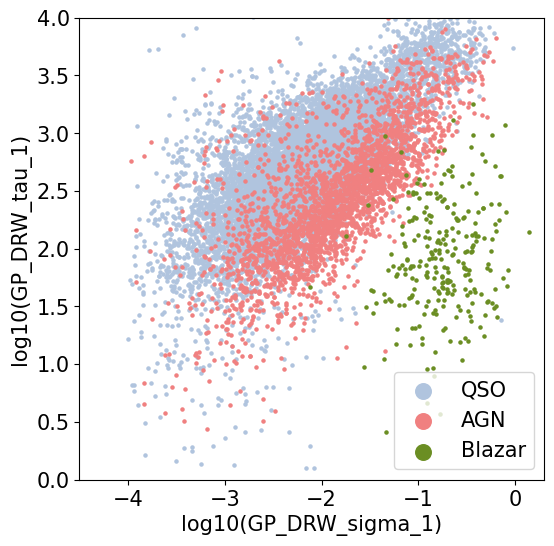

In [51]:
feature_x = 'GP_DRW_sigma_1'
feature_y = 'GP_DRW_tau_1'

fig, ax = plt.subplots(figsize=(6, 6)) 

objects_aux = objects[(objects[feature_x] >= 1e-4) \
              & (objects[feature_y]>=1)] # we want to avoid incorrect measurements 

for class_name, color in [("QSO", "lightsteelblue"),
                          ("AGN", "lightcoral"),
                          ("Blazar", "olivedrab")]:
    plt.scatter(np.log10(objects_aux.loc[objects_aux["class_name"] \
                         == class_name,feature_x].values),
                np.log10(objects_aux.loc[objects_aux["class_name"] \
                         == class_name,feature_y].values),
                c=color, s=5, label=class_name)


plt.ylabel("log10(%s)" % (feature_y), fontsize=15)
plt.xlabel("log10(%s)" % (feature_x), fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, markerscale=5)
plt.ylim(0, 4)
plt.xlim(-4.5, 0.3);

It can be seen that QSOs, AGNs, and Blazars occupy different locations in this plot, with Blazars showing larger values of GP\_DRW\_sigma\_1. This behavior was also found in a previous analysis presented by [Ruan et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...760...51R/abstract).

## Close the connection

In [52]:
conn.close()